# March Machine Learning Madness 2024: Modeling
### Predicting NCAA Basketball Tournament Results
##### From the [Kaggle Competition: "March Machine Learning Mania 2024"](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview)
##### By David Hartsman

### Overview:
In the previous notebook, I prepared data by selecting elements from over 30 different file sources. In this notebook, I will use that data to begin training models with the purpose of correctly predicting NCAA Tournament games. I have created 4 different target values:
- Binary W/L Target
- Continuous Team_A Pts Scored
- Continuous Team_B Pts Scored
- Continuous Team_A - Team_B Pts Differential

I will begin this notebook by attempting to build a successful classification model using algorithms from the Scikit-Learn Library. Depending on those results, I may move on and attempt to develop accurate Linear Regression models as well. 

<hr style="border: 4px solid blue">

In [50]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

# Sklearn Accessories
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, auc, roc_curve, \
roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Model Types
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier,\
GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from classification_classes import Model
import xgboost
from xgboost import XGBClassifier


pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Feature Curation
</div>
After loading in the data, I will take a few final steps to prepare the data for modeling. I will select the features that I would like to use. As a starting point, I will opt to use as many features as possible, and subsequently weed out any features that may not be contributing much signal. 

I will also be creating "dummy" predictions. These predictions will be created by:

- A.) Choosing the lower of the 2 "Chalk_Seeds" as the winner, and
- B.) If the seeds are the same, choosing the team with the better winning percentage

These predictions are equivalent to picking *"chalk"*, or the on-paper favorite in every match-up without the benefit of any additional analysis. 

After that, I will perform a train-test split and create an sklearn pipeline to handle pre-modeling transformations such as *scaling* and *one-hot-encoding*. Then, utilize a class-object that I have created to store the results and metrics of different model iterations. 

In [7]:
# Load in data

# Create a path reference for easier readability 
path = '/Users/samalainabayeva/Desktop/FLAT_IRON!!!/NCAA_KAGGLE/march-machine-learning-mania-2024/'

# Load and inspect the data
df = pd.read_csv(os.path.join(path, 'Data_For_Modeling.csv'), index_col=0)
df.head()

,DayNum,League,Season,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_BestRanking,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_Coach,Team_A_Conference,...,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_TeamID,Team_B_Total3ptAtt,Team_B_Total3ptMade,Team_B_TotalFGAtt,Team_B_TotalFGMade,Team_B_Total_Assts,Team_B_Total_Def_Rebs,Team_B_Total_FT_Att,Team_B_Total_FT_Made,Team_B_Total_Off_Rebs,Team_B_Total_TO,Team_B_WinTrend,Team_B_Win_Total,Team_B_WorstRanking,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,Team_A_Win,Game_Point_Differential
1136,134,Men,2003,18.500000,5.933333,55.266667,24.733333,70.833333,1.966667,72.800000,14.200000,2.233333,24.800000,28.066667,17.400000,18.300000,13.166667,6.433333,15.233333,233.0,16.0,14.0,9.0,NaN,swac,...,13.064637,11.638542,17.508478,1421,522.0,188.0,1647.0,707.0,378.0,672.0,607.0,463.0,356.0,470.0,Downtrend,13.0,309.0,0.700000,0.833333,1.00,1.000000,0.125000,0.448276,0,-8
1137,136,Men,2003,20.071429,7.035714,65.714286,30.321429,70.250000,14.964286,85.214286,17.642857,4.214286,27.642857,25.000000,17.535714,17.750000,15.178571,8.464286,14.785714,1.0,1.0,5.0,3.0,NaN,pac_ten,...,10.384481,11.995176,12.601802,1436,449.0,153.0,1620.0,720.0,412.0,746.0,567.0,373.0,376.0,408.0,Uptrend,19.0,191.0,0.428571,0.900000,0.60,0.000000,0.500000,0.655172,1,29
1138,136,Men,2003,12.586207,4.000000,56.896552,27.206897,69.172414,6.793103,75.965517,15.551724,4.241379,23.310345,26.206897,17.551724,19.413793,13.689655,5.206897,14.000000,53.0,10.0,8.0,4.0,NaN,pac_ten,...,11.354889,8.724435,10.964565,1272,582.0,203.0,1740.0,762.0,482.0,753.0,664.0,434.0,408.0,400.0,Uptrend,23.0,29.0,0.500000,0.875000,1.00,0.000000,0.636364,0.793103,1,13
1139,136,Men,2003,20.484848,7.969697,57.454545,28.696970,64.333333,14.909091,79.242424,16.818182,4.454545,23.181818,20.030303,13.878788,17.272727,10.878788,8.393939,13.363636,18.0,6.0,7.0,6.0,NaN,mvc,...,10.168773,13.102006,13.167451,1141,520.0,198.0,1528.0,772.0,453.0,675.0,730.0,559.0,307.0,529.0,Uptrend,23.0,102.0,0.800000,0.916667,1.00,NaN,0.642857,0.793103,0,-6
1140,136,Men,2003,22.500000,7.966667,53.333333,24.333333,68.000000,4.400000,72.400000,14.666667,3.066667,22.033333,20.466667,15.766667,18.666667,9.733333,7.766667,14.200000,51.0,9.0,4.0,2.0,NaN,acc,...,10.411721,7.758040,10.666692,1143,494.0,186.0,1703.0,793.0,464.0,707.0,566.0,388.0,326.0,411.0,Downtrend,21.0,33.0,0.571429,0.928571,0.25,0.333333,0.636364,0.724138,0,-2


<hr style="border: 2px solid blue">

### Creating Dummy Predictions

In [8]:
# Inspecting the criteria for generating dummy predictions 

df[["Team_A_Chalk_Seed", 'Team_B_Chalk_Seed', "Team_A_win_perc", 'Team_B_win_perc']].head()

,Team_A_Chalk_Seed,Team_B_Chalk_Seed,Team_A_win_perc,Team_B_win_perc
1136,16.0,16.0,0.600000,0.448276
1137,1.0,16.0,0.892857,0.655172
1138,10.0,7.0,0.620690,0.793103
1139,6.0,11.0,0.878788,0.793103
1140,9.0,8.0,0.600000,0.724138


In [124]:
# Function to get dummy predictions

def get_dummy_preds(data):

    # Create a container
    dummy_preds = []

    # Loop through the dataframe based on conditions
    for idx, row in data.iterrows():
        if data.loc[idx, "Team_A_Chalk_Seed"] < data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(1)
        elif data.loc[idx, "Team_A_Chalk_Seed"] > data.loc[idx, "Team_B_Chalk_Seed"]:
            dummy_preds.append(0)
        else:
            if data.loc[idx, "Team_A_win_perc"] > data.loc[idx, "Team_B_win_perc"]:
                dummy_preds.append(1)
            else:
                dummy_preds.append(0)
    
    return np.array(dummy_preds)

df["Dummy_Predictions"] = get_dummy_preds(df)

<hr style="border: 2px solid blue">

### Selecting Features for Modeling
Currently, the data has 188 different columns, but several of those columns are targets, or redundant aggregated statistics. Also, due to the variety of different sources, a huge amount of rows contain null or missing value, and they are outside the typically advised number of rows to drop without sacrificing data integrity. Still, in lieu of better alternatives, I will drop them for the time being. I will still attempt to include as many rows and features as possible. 

There are 441 missing/null values in much of the data, likely due to incomplete information for certain years and certain teams. This amounts to 17.1% of the overall data. Unfortunately, it will have to be dropped. 

In [83]:
# Dropping the 441 rows from all columns 

dropped = df.dropna(subset=["Team_A_Avg3ptAtt"]).copy()

The majority of the remaining null values fall in to two different categories. Columns containing ranking data from the Massey file in the previous notebook, as this information was only available for men after a certain year. This ranking data will be dropped from our modeling for the time being. The remaining nulls mostly stem from zero-division issues for teams having 0 close games, overtime games, etc. Those values can be more easily imputed. 

I will be dropping the following features:

- DayNum as it does not provide any team-specific data
- Season as it was only used for joining data and shouldn't contain any signal
- Ranking Columns 
- Coach as once again it was only available for men
- Most Columns Containing Season Totals as opposed to averages

In [84]:
# Dropping these features, target columns are still included for the time being

columns_to_drop = ['DayNum', "Season", 'Team_A_BestRanking', 'Team_A_Coach', "Team_A_DiffTrend", \
                   "Team_A_MedianRanking", 'Team_A_TeamID', 'Team_A_Total3ptAtt', 'Team_A_Total3ptMade', \
                   'Team_A_TotalFGAtt', 'Team_A_TotalFGMade', 'Team_A_Total_Assts', 'Team_A_Total_Def_Rebs', \
                   'Team_A_Total_FT_Att', 'Team_A_Total_FT_Made', 'Team_A_Total_Off_Rebs', 'Team_A_Total_TO', \
                   'Team_A_WinTrend', 'Team_A_WorstRanking', 'Team_A_Seed', \
                  'Team_B_BestRanking', 'Team_B_Coach', "Team_B_DiffTrend", \
                   "Team_B_MedianRanking", 'Team_B_TeamID', 'Team_B_Total3ptAtt', 'Team_B_Total3ptMade', \
                   'Team_B_TotalFGAtt', 'Team_B_TotalFGMade', 'Team_B_Total_Assts', 'Team_B_Total_Def_Rebs', \
                   'Team_B_Total_FT_Att', 'Team_B_Total_FT_Made', 'Team_B_Total_Off_Rebs', 'Team_B_Total_TO', \
                   'Team_B_WinTrend', 'Team_B_WorstRanking', 'Team_B_Seed']

print(f"Dropping {len(columns_to_drop)} features")

Dropping 38 features


In [85]:
# Re-assigning the variable
dropped = dropped.drop(columns=columns_to_drop)

In [99]:
# These columns have categorical information

object_columns = ["League", 'Team_A_Conference', 'Team_A_Loc', 'Team_A_Relative_Diff_Trend', \
                  'Team_A_Relative_Win_Trend',\
                  'Team_B_Conference', 'Team_B_Loc', 'Team_B_Relative_Diff_Trend', 'Team_B_Relative_Win_Trend']

# Changing the dtype
for i in object_columns:
    dropped[i] = dropped[i].astype("category")
    
    
# Inspecting the new dtypes
dropped[object_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2142 entries, 1136 to 4033
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   League                      2142 non-null   category
 1   Team_A_Conference           2142 non-null   category
 2   Team_A_Loc                  2142 non-null   category
 3   Team_A_Relative_Diff_Trend  2142 non-null   category
 4   Team_A_Relative_Win_Trend   2142 non-null   category
 5   Team_B_Conference           2142 non-null   category
 6   Team_B_Loc                  2142 non-null   category
 7   Team_B_Relative_Diff_Trend  2142 non-null   category
 8   Team_B_Relative_Win_Trend   2142 non-null   category
dtypes: category(9)
memory usage: 39.1 KB


### D-type Breakdown:
There are 150 columns remaining at this point. 145 of those are actually features.

- 9 columns are objects/categories
- 136 are currently saved as float64, 9 + 136 = 145
- The remaining 5 columns are the 4 target values and 1 dummy predictions

**Now......** I have the data and features selected, and I will begin the final preparation for modeling. This will include assigning X and y variables, conducting a train test split, and instantiating sklearn pipelines to handle data transformations. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Model Creation:</b> Final Pre-Processing
</div>

### Splitting Data

In [126]:
# Assigning X and y variables, train-test split

# Features
X = dropped.drop(columns=["Team_A_Score", "Team_B_Score", "Team_A_Win", 'Game_Point_Differential', \
                          "Dummy_Predictions"])

# Target
y = dropped["Team_A_Win"]

# Train-test split, 25% Test Size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=.25, shuffle=True, stratify=y)

In [136]:
# Creating Pipeline objects

numeric_pipe = Pipeline(steps=[
    ("si", SimpleImputer(add_indicator=True, strategy="median")),
    ("mms", MinMaxScaler())
])

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ct = ColumnTransformer(transformers=[
    ("num_pipe", numeric_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])


pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', LogisticRegression())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe43f6d11e0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe43f6d1210>)])),
                ('model', LogisticRegression())])

In [137]:
# First Model Creation

logistic_1 = Model("Baseline Logistic Regression", pipe_model, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer t

In [152]:
# Dummy logic Test Predictions

dummy = {"name":"Dummy Selection Logic", 
         "train_accuracy": accuracy_score(y_train, get_dummy_preds(X_train)),
         "train_prec": precision_score(y_train, get_dummy_preds(X_train)),
         "train_recall": recall_score(y_train, get_dummy_preds(X_train)),
         "train_f1": f1_score(y_train, get_dummy_preds(X_train)),
         "train_logloss": log_loss(y_train, get_dummy_preds(X_train)), 
         "test_accuracy":accuracy_score(y_test, get_dummy_preds(X_test)),
        "test_prec": precision_score(y_test, get_dummy_preds(X_test)),
        "test_recall": recall_score(y_test, get_dummy_preds(X_test)),
        "test_f1":f1_score(y_test, get_dummy_preds(X_test)),
        "test_logloss":log_loss(y_test, get_dummy_preds(X_test))}
Model.model_df.loc[1] = dummy

In [153]:
# Data for the first model iteration:

Model.model_df

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.53054,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.56077,0.716418,0.705263,0.747212,0.725632,10.221335,NaN


<hr style="border: 2px solid blue">

### Class and Functions to extract the largest coefficients or feature importances from models

In [218]:
# Class for collecting coefficients of models based on economic features

class Importance():
    
    global pipe_model
    df = pd.DataFrame(columns=list(pipe_model.get_params()["ct"].get_feature_names_out()))
    df.columns = [i.replace("num_pipe__", "").replace("cat_pipe__", "") for i in df.columns]
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        

    
# Functions to aid in collection

# Extract Feature Importance from Tree-based Models

def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)
        


# Extracts the coefficients from Logistic Regression models and pairs them with their features

def coefs_from_lr(model_class, number_of_coefs):
    features = model_class.model.named_steps["ct"].get_feature_names_out()
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
    
    coef_feats = model_class.model.get_params()['model'].coef_[0]
    
    imp_list = list(zip(features_list, coef_feats))
    imp_dict = dict(imp_list)
    
    Importance(imp_dict)

    print(f"Top {number_of_coefs} Feature Coefficients by Absolute Value")
    for i in sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)[:number_of_coefs]:
        print(i)
    
    return sorted(imp_list, key=lambda x: np.abs(x[1]), reverse=True)

In [219]:
# Extracting the coefficient values of the model
logreg_coef = coefs_from_lr(logistic_1, 20)

Top 20 Feature Coefficients by Absolute Value
('Team_B_Chalk_Seed', 2.204177963957876)
('Team_A_Chalk_Seed', -1.9596564804475771)
('Team_A_Avg_Blocks', 1.3214986388136671)
('Team_B_Avg_FT_Att', 1.1218521914384205)
('Team_A_OppAvg_Def_Rebs', -0.9453435179365078)
('missingindicator_Team_A_neutral_win_perc', -0.9034837612784214)
('Team_B_AvgFGMade', -0.8575103352067229)
('Team_A_OppTotal_TO', 0.8460844439998738)
('Team_B_AvgPtDiff', -0.8030972080422378)
('Team_A_Avg_Def_Rebs', -0.7797466966230125)
('Team_A_LastFivePtDiff', -0.7550556215710919)
('Team_A_AvgFGMade', 0.7502056222700226)
('Team_B_OppAvg_Def_Rebs', 0.7434198692376042)
('Team_A_close_game_win_perc', -0.710330332757669)
('Team_B_AvgTeamScore', -0.7075940792473261)
('Team_B_LastTenWinPerc', -0.674712852579036)
('Team_A_OppAvg_FT_Att', -0.6596901185313329)
('Team_A_AvgTeamScore', 0.6407673822894853)
('Team_A_AvgPtDiff', 0.6374009159285827)
('Team_B_OppAvg_Assts', 0.6269364198648412)


In [255]:
# Function to query and compare specific statistics, although the same could be done in pandas

def assess_features(feature_list:list, statistic:str):
    """
    Function to return the coefficients or importances of a category of statistics, i.e. "AvgTeamScore" or "AvgPtDiff"
    
    Parameters
    ---------------
    feature_list : list
        list of features extracted from either features_from_trees() or coefs_from_lr()
    statistic: string
        string name of the desired statistic as seen in the initial description
        
    Returns
    ---------------
    out : list of tuples containing the statistic and its respective coefficient/feature importance
    """
    return [feature_list[i] for i, _ in enumerate(feature_list) if statistic in feature_list[i][0]] 

In [254]:
Importance.df[["Team_B_AvgTeamScore", 'Team_A_AvgTeamScore']]

,Team_B_AvgTeamScore,Team_A_AvgTeamScore
Baseline Logistic Regression,-0.707594,0.640767


In [250]:
assess_features(logreg_coef, "AvgTeamScore")

[('Team_B_AvgTeamScore', -0.7075940792473261),
 ('Team_A_AvgTeamScore', 0.6407673822894853)]

In [252]:
assess_features(logreg_coef, "Avg3ptMade")

[('Team_A_OppAvg3ptMade', -0.3787169289003056),
 ('Team_B_OppAvg3ptMade', 0.18290084697296688),
 ('Team_A_Avg3ptMade', 0.08862787919102433),
 ('Team_B_Avg3ptMade', -0.02121392647989132)]

In [226]:
logreg_coef[0]

('Team_B_Chalk_Seed', 2.204177963957876)

In [224]:
# Largest Negative Coefficients
# Importance.df.rename(index={0:"Baseline Logistic Regression"}, inplace=True)
Importance.df

,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_RoadLoss,Team_A_RoadWins,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_Win_Total,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_RoadLoss,Team_B_RoadWins,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_Win_Total,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,missingindicator_Team_A_close_game_win_perc,missingindicator_Team_A_home_win_perc,missingindicator_Team_A_neutral_win_perc,missingindicator_Team_A_ot_win_perc,missingindicator_Team_B_close_game_win_perc,missingindicator_Team_B_home_win_perc,missingindicator_Team_B_neutral_win_perc,missingindicator_Team_B_ot_win_perc
Baseline Logistic Regression,0.225952,0.088628,0.223829,0.750206,-0.228961,0.637401,0.640767,0.261619,1.321499,-0.779747,0.132728,0.003858,-0.356515,-0.048486,0.037132,-0.283606,-1.959656,0.109863,-0.080853,0.132631,0.156717,-0.755056,-0.352683,-0.447223,-0.3946,0.131736,-0.011977,0.370245,-0.064396,0.06043,0.189868,-0.218025,-0.064844,0.146813,-0.378717,0.001674,-0.276944,-0.108129,-0.013056,-0.945344,-0.65969,0.215983,-0.482475,-0.407308,-0.227351,0.435784,0.147324,-0.396221,0.427905,0.19019,0.164117,-0.171571,-0.466357,0.309962,0.039398,0.846084,0.074796,0.23817,-0.588126,-0.274784,0.608385,0.405711,-0.71033,0.111432,0.137371,-0.22349,0.573781,-0.161711,0.321314,-0.021214,-0.218538,-0.85751,0.349252,-0.803097,-0.707594,0.382983,-0.20495,-0.105482,1.121852,-0.036896,0.569705,-0.535131,-0.264348,0.294932,2.204178,0.385708,-0.231818,-0.48063,0.013843,-0.152546,-0.35263,0.059082,-0.674713,-0.28634,-0.117243,0.282191,-0.420201,-0.443234,-0.589267,-0.303976,0.299677,0.014839,0.182901,0.569851,0.333587,0.626936,-0

<hr style="border: 2px solid blue">

### Observations on the First Model:

Unfortunately, the Logistic Regression model with default hyperparameters failed to outperform predictions made solely based on "Chalk_Seed" and "Win_Pct". The features with the two largest magnitude coefficients made total sense: Seeds. The other largest coefficients were a mixture of different statistics. Hopefully, different model types may prove more successful at predicting outcomes. 

<hr style="border: 2px solid blue">

<div class="alert alert-block alert-info" style="font-size: 2em;">
<b>Additional Model Iterations:</b>
</div>
Next, I will fit different types of models to the data and compare the accuracy of these models to our baseline Logistic Regression and dummy model.

In [265]:
# Fitting a RandomForestClassifier

pipe_model = Pipeline(steps=[
    ("ct", ct),
    ('model', XGBClassifier())
])

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median')),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe43f6d11e0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [266]:
# Instantiation and saving data to the class

# Default Random Forest Classifier - worst accuracy so far
# random_forest = Model("Random Forest Classifier", pipe_model, X_train, X_test, y_train, y_test)

# Extra Trees Classifier - still significantly worse
# extra_trees = Model("Extra Trees Classifier", pipe_model, X_train, X_test, y_train, y_test)

# KNN Classifier - worst out of 5
# knn = Model("KNN Classifier", pipe_model, X_train, X_test, y_train, y_test)

# XG Boost - middle of the pack
# xgb = Model("XGBoost Classifier", pipe_model, X_train, X_test, y_train, y_test)

Model.model_df.sort_values("test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future ver

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
1,Dummy Selection Logic,0.734745,0.739021,0.729864,0.734414,9.560770,0.716418,0.705263,0.747212,0.725632,10.221335,NaN
0,Baseline Logistic Regression,0.726635,0.728829,0.729829,0.728665,0.530540,0.712687,0.694915,0.762082,0.726950,0.536016,0.804617
3,Extra Trees Classifier,0.712308,0.718041,0.709999,0.712988,0.548325,0.686567,0.686347,0.691450,0.688889,0.569758,0.768709
5,XGBoost Classifier,0.715425,0.728680,0.695100,0.710133,0.702211,0.679104,0.673835,0.698885,0.686131,0.837950,0.760787
2,Random Forest Classifier,0.718535,0.727644,0.706326,0.716394,0.557380,0.673507,0.660959,0.717472,0.688057,0.577820,0.764219
4,KNN Classifier,0.657528,0.660910,0.656759,0.658195,1.388824,0.639925,0.643939,0.631970,0.637899,1.968196,0.688644


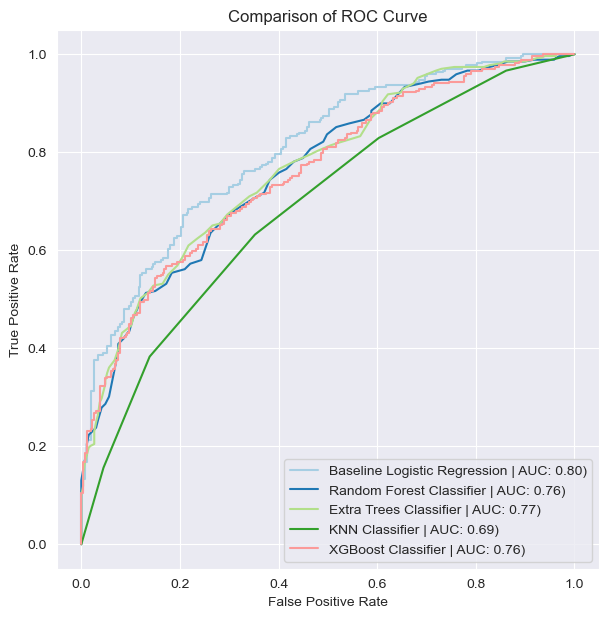

In [269]:
# Looking at ROC Curves to assess overall model performance
xgb.compare_roc_curve()
plt.grid(True)

In [272]:
# Extracting Feature Importances from Tree Models

# features_from_trees(random_forest)
# features_from_trees(extra_trees)
# features_from_trees(xgb)
# Importance.df.rename(index={1: "RFC", 2:"Extra Trees", 3:"XGB"}, inplace=True)
Importance.df

Top 5 Feature Importances
('Team_A_Chalk_Seed', 0.05215968561639947)
('Team_B_Chalk_Seed', 0.04602993081751889)
('Team_B_LastTenWinPerc', 0.016626720945315303)
('Team_B_AvgPtDiff', 0.013782115832162748)
('Team_A_AvgPtDiff', 0.012850918445003202)
Top 5 Feature Importances
('Team_B_Chalk_Seed', 0.049532652)
('Team_A_Chalk_Seed', 0.034928944)
('Team_B_MedPtDiff', 0.026930457)
('Team_B_win_perc', 0.02019445)
('Team_B_Win_Total', 0.016553346)


,Team_A_Avg3ptAtt,Team_A_Avg3ptMade,Team_A_AvgFGAtt,Team_A_AvgFGMade,Team_A_AvgOppScore,Team_A_AvgPtDiff,Team_A_AvgTeamScore,Team_A_Avg_Assts,Team_A_Avg_Blocks,Team_A_Avg_Def_Rebs,Team_A_Avg_FT_Att,Team_A_Avg_FT_Made,Team_A_Avg_Fouls,Team_A_Avg_Off_Rebs,Team_A_Avg_Steals,Team_A_Avg_TO,Team_A_Chalk_Seed,Team_A_CloseGames,Team_A_CloseWins,Team_A_HomeLoss,Team_A_HomeWins,Team_A_LastFivePtDiff,Team_A_LastFiveWinPerc,Team_A_LastTenPtDiff,Team_A_LastTenWinPerc,Team_A_Loss_Total,Team_A_MaxLStreak,Team_A_MaxWStreak,Team_A_MedPtDiff,Team_A_NeutralLoss,Team_A_NeutralWins,Team_A_OTLoss,Team_A_OTWins,Team_A_OppAvg3ptAtt,Team_A_OppAvg3ptMade,Team_A_OppAvgFGAtt,Team_A_OppAvgFGMade,Team_A_OppAvg_Assts,Team_A_OppAvg_Blocks,Team_A_OppAvg_Def_Rebs,Team_A_OppAvg_FT_Att,Team_A_OppAvg_FT_Made,Team_A_OppAvg_Fouls,Team_A_OppAvg_Off_Rebs,Team_A_OppAvg_Steals,Team_A_OppAvg_TO,Team_A_OppTotal3ptAtt,Team_A_OppTotal3ptMade,Team_A_OppTotalFGAtt,Team_A_OppTotalFGMade,Team_A_OppTotal_Assts,Team_A_OppTotal_Def_Rebs,Team_A_OppTotal_FT_Att,Team_A_OppTotal_FT_Made,Team_A_OppTotal_Off_Rebs,Team_A_OppTotal_TO,Team_A_RoadLoss,Team_A_RoadWins,Team_A_StdDevOppScore,Team_A_StdDevTeamScore,Team_A_StdPtDiff,Team_A_Win_Total,Team_A_close_game_win_perc,Team_A_home_win_perc,Team_A_neutral_win_perc,Team_A_ot_win_perc,Team_A_road_win_perc,Team_A_win_perc,Team_B_Avg3ptAtt,Team_B_Avg3ptMade,Team_B_AvgFGAtt,Team_B_AvgFGMade,Team_B_AvgOppScore,Team_B_AvgPtDiff,Team_B_AvgTeamScore,Team_B_Avg_Assts,Team_B_Avg_Blocks,Team_B_Avg_Def_Rebs,Team_B_Avg_FT_Att,Team_B_Avg_FT_Made,Team_B_Avg_Fouls,Team_B_Avg_Off_Rebs,Team_B_Avg_Steals,Team_B_Avg_TO,Team_B_Chalk_Seed,Team_B_CloseGames,Team_B_CloseWins,Team_B_HomeLoss,Team_B_HomeWins,Team_B_LastFivePtDiff,Team_B_LastFiveWinPerc,Team_B_LastTenPtDiff,Team_B_LastTenWinPerc,Team_B_Loss_Total,Team_B_MaxLStreak,Team_B_MaxWStreak,Team_B_MedPtDiff,Team_B_NeutralLoss,Team_B_NeutralWins,Team_B_OTLoss,Team_B_OTWins,Team_B_OppAvg3ptAtt,Team_B_OppAvg3ptMade,Team_B_OppAvgFGAtt,Team_B_OppAvgFGMade,Team_B_OppAvg_Assts,Team_B_OppAvg_Blocks,Team_B_OppAvg_Def_Rebs,Team_B_OppAvg_FT_Att,Team_B_OppAvg_FT_Made,Team_B_OppAvg_Fouls,Team_B_OppAvg_Off_Rebs,Team_B_OppAvg_Steals,Team_B_OppAvg_TO,Team_B_OppTotal3ptAtt,Team_B_OppTotal3ptMade,Team_B_OppTotalFGAtt,Team_B_OppTotalFGMade,Team_B_OppTotal_Assts,Team_B_OppTotal_Def_Rebs,Team_B_OppTotal_FT_Att,Team_B_OppTotal_FT_Made,Team_B_OppTotal_Off_Rebs,Team_B_OppTotal_TO,Team_B_RoadLoss,Team_B_RoadWins,Team_B_StdDevOppScore,Team_B_StdDevTeamScore,Team_B_StdPtDiff,Team_B_Win_Total,Team_B_close_game_win_perc,Team_B_home_win_perc,Team_B_neutral_win_perc,Team_B_ot_win_perc,Team_B_road_win_perc,Team_B_win_perc,missingindicator_Team_A_close_game_win_perc,missingindicator_Team_A_home_win_perc,missingindicator_Team_A_neutral_win_perc,missingindicator_Team_A_ot_win_perc,missingindicator_Team_B_close_game_win_perc,missingindicator_Team_B_home_win_perc,missingindicator_Team_B_neutral_win_perc,missingindicator_Team_B_ot_win_perc
Baseline Logistic Regression,0.225952,0.088628,0.223829,0.750206,-0.228961,0.637401,0.640767,0.261619,1.321499,-0.779747,0.132728,0.003858,-0.356515,-0.048486,0.037132,-0.283606,-1.959656,0.109863,-0.080853,0.132631,0.156717,-0.755056,-0.352683,-0.447223,-0.394600,0.131736,-0.011977,0.370245,-0.064396,0.060430,0.189868,-0.218025,-0.064844,0.146813,-0.378717,0.001674,-0.276944,-0.108129,-0.013056,-0.945344,-0.659690,0.215983,-0.482475,-0.407308,-0.227351,0.435784,0.147324,-0.396221,0.427905,0.190190,0.164117,-0.171571,-0.466357,0.309962,0.039398,0.846084,0.074796,0.238170,-0.588126,-0.274784,0.608385,0.405711,-0.710330,0.111432,0.137371,-0.223490,0.573781,-0.161711,0.321314,-0.021214,-0.218538,-0.857510,0.349252,-0.803097,-0.707594,0.382983,-0.204950,-0.105482,1.121852,-0.036896,0.569705,-0.535131,-0.264348,0.294932,2.204178,0.385708,-0.231818,-0.480630,0.013843,-0.152546,-0.352630,0.059082,-0.674713,-0.286340,-0.117243,0.282191,-0.420201,-0.443234,-0.589267,-0.303976,0.299677,0.014839,0.182901,0.569851,0.33358

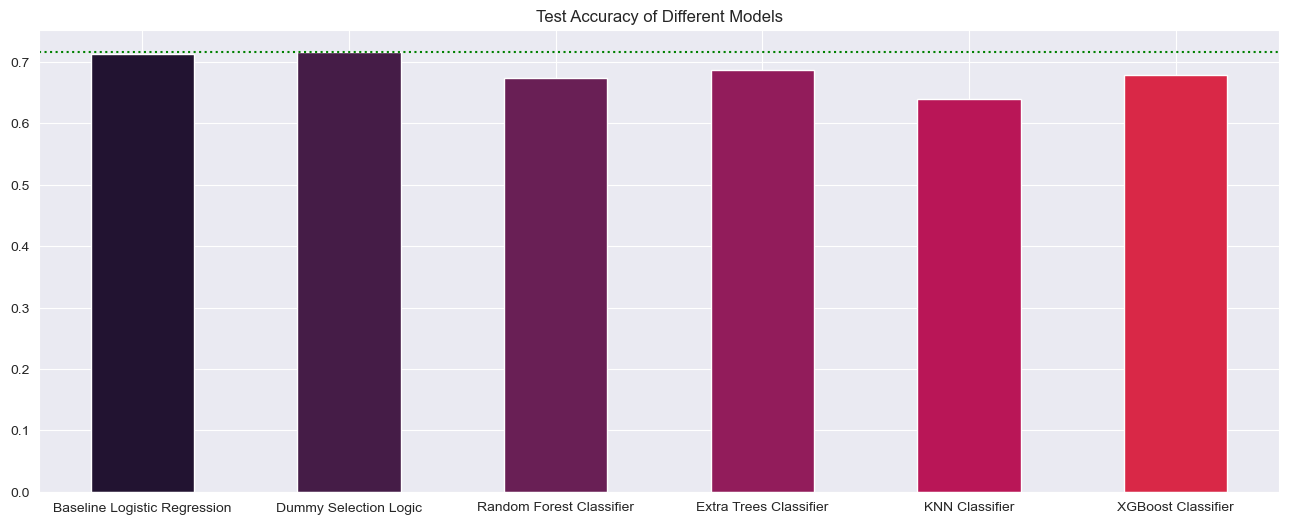

In [338]:
# Plotting Test Accuracy
fig, ax = plt.subplots(figsize = (16, 6))
pal = sns.color_palette("rocket", n_colors=10)
Model.model_df["test_accuracy"].plot(kind="bar", title="Test Accuracy of Different Models", color=pal)
ax.set_xticklabels(Model.model_df["name"], rotation = 0)
ax.axhline(Model.model_df.query("name == 'Dummy Selection Logic'")["test_accuracy"].values, \
           linestyle = ":", color="green")
plt.grid(True);

### Observations For These Models:
Again, I am consistently observing that the models use the respective Chalk Seeds as the most important feature. Given that none of these models have performed better than the dummy logic. I will have to attempt to adjust the features and target values in hopes of achieving better results. 